# Scope of the Notebook (Enhanced)

1. **Download the breast tumor image dataset from a public web source.**
   - Use the BUSI dataset.
   - Organize the data into train/test splits, preparing for K-Fold Cross-Validation.

2. **Develop a CNN-Transformer hybrid model.**
   - Implement the model architecture using PyTorch.
   - Combine a pre-trained ResNet-50 for feature extraction and transformer blocks for global context.

3. **Train the model using a robust training pipeline.**
   - **Advanced Augmentation:** Use the `albumentations` library for more realistic augmentations like ElasticTransform.
   - **K-Fold Cross-Validation:** Train and validate the model across 5 different folds to get a more reliable performance metric.
   - **Learning Rate Scheduler:** Implement `CosineAnnealingLR` to dynamically adjust the learning rate.
   - **Early Stopping:** Prevent overfitting by stopping training when validation performance stagnates.

4. **Test the model on the test dataset using Test-Time Augmentation (TTA).**
   - Evaluate average accuracy, precision, recall, and F1-score across all folds.

5. **Plot the confusion matrix for test predictions.**
   - Visualize the aggregated model performance across all classes and folds.

6. **Summarize findings and discuss potential improvements.**

# 1. Data Loading and Exploration
First, we'll import the necessary libraries and load our dataset from the local directory.

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.models as models
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

## Dataset Overview

The image dataset contains three classes: **malignant**, **normal**, and **benign**. We will load all image paths and labels first.

In [14]:
dataset_path = r"Dataset_BUSI_with_GT"
classes = ['malignant', 'normal', 'benign']

images = []
labels = []

for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    for fname in os.listdir(cls_path):
        if 'mask' not in fname:
            img_path = os.path.join(cls_path, fname)
            images.append(img_path)
            labels.append(i)

images = np.array(images)
labels = np.array(labels)

print(f"Found {len(images)} images belonging to {len(classes)} classes.")

Found 780 images belonging to 3 classes.


# 2. Data Preparation with Advanced Augmentation

We will now use the `albumentations` library to create a more powerful augmentation pipeline. We will also define our PyTorch `Dataset` class, which will handle loading and transforming the images.

In [19]:
# Define advanced transformations using Albumentations
data_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.ElasticTransform(p=0.5, alpha=120, sigma=6),
        A.RandomBrightnessContrast(p=0.5),
        A.CoarseDropout(num_holes_range=(4, 8), hole_height_range=(8, 16), hole_width_range=(8, 16), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
}

class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Albumentations works with NumPy arrays, so we read with OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # Duplicate channels for pre-trained model
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, label

# 3. CNN-Transformer Hybrid Model

The model architecture remains the same: a ResNet-50 feature extractor followed by a Transformer Encoder.

In [20]:
class CNNViTHybrid(nn.Module):
    def __init__(self, num_classes, cnn_backbone='resnet50', embed_dim=256, nhead=8, num_layers=6):
        super(CNNViTHybrid, self).__init__()
        
        # CNN Backbone (Feature Extractor)
        if cnn_backbone == 'resnet50':
            cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            self.feature_extractor = nn.Sequential(*list(cnn.children())[:-2])
            cnn_output_channels = 2048 # ResNet50's last conv block channels
        else:
            raise ValueError("Unsupported CNN backbone")
            
        # Positional Encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, 50, embed_dim)) # 7x7 feature map + 1 cls token
        
        # Projection layer to match Transformer's embedding dimension
        self.projection = nn.Conv2d(cnn_output_channels, embed_dim, kernel_size=1)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification Head
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # 1. Extract features with CNN
        x = self.feature_extractor(x) # Output shape: (batch, 2048, 7, 7)
        
        # 2. Project to Transformer's embedding dimension
        x = self.projection(x) # Output shape: (batch, 256, 7, 7)
        
        # 3. Flatten and prepare for Transformer
        b, c, h, w = x.shape
        x = x.flatten(2).permute(0, 2, 1) # Shape: (batch, 49, 256)
        
        # 4. Add CLS token
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # Shape: (batch, 50, 256)
        
        # 5. Add positional encoding
        x += self.pos_encoder
        
        # 6. Pass through Transformer Encoder
        x = self.transformer_encoder(x) # Shape: (batch, 50, 256)
        
        # 7. Use the output of the CLS token for classification
        cls_output = x[:, 0]
        output = self.classifier(cls_output)
        
        return output

# 4. K-Fold Cross-Validation Training Loop

We now implement the full training pipeline inside a K-Fold loop. The data is first split into a training+validation set (85%) and a final hold-out test set (15%). The 5-fold cross-validation is performed on the 85% chunk.

**Inside each fold, we will:**
1. Re-initialize the model, optimizer, and learning rate scheduler.
2. Train for a set number of epochs.
3. Use **Early Stopping** to halt training if the validation loss does not improve for 5 consecutive epochs.
4. Save the best model from that fold based on validation loss.
5. Store the validation and test metrics for later averaging.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# First, split into a training+validation set and a final test set
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.15, random_state=42, stratify=labels)

# K-Fold Cross-Validation Setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

history = {'val_acc': [], 'val_loss': []}
test_preds_all_folds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f'\n--- Fold {fold+1}/{n_splits} ---')

    # --- Data Preparation for this Fold ---
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    train_dataset = BreastCancerDataset(X_train, y_train, transform=data_transforms['train'])
    val_dataset = BreastCancerDataset(X_val, y_val, transform=data_transforms['val'])

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # --- Model, Loss, Optimizer, and Scheduler Initialization ---
    model = CNNViTHybrid(num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    num_epochs = 50 # Set a higher max epoch for early stopping
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # --- Early Stopping Initialization ---
    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0
    best_model_path = f'best_model_fold_{fold+1}.pth'

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        for inputs, labels_batch in train_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels_batch in val_loader:
                inputs, labels_batch = inputs.to(device), labels_batch.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_batch)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels_batch.data)

        val_loss = val_loss / len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)
        print(f'Epoch {epoch+1}/{num_epochs} -> Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        scheduler.step()

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f'Validation loss decreased. Saving model to {best_model_path}')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print('Early stopping!')
            break
            
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # --- Testing on Hold-out Set for this Fold's Best Model ---
    test_dataset_fold = BreastCancerDataset(X_test, y_test, transform=data_transforms['val'])
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=batch_size, shuffle=False)
    
    # Load the best model from this fold
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    fold_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader_fold:
            inputs = inputs.to(device)
            outputs = model(inputs)
            fold_preds.append(outputs.cpu())
    test_preds_all_folds.append(torch.cat(fold_preds))
    

print(f"\nAverage Validation Accuracy: {np.mean(history['val_acc']):.4f} +/- {np.std(history['val_acc']):.4f}")

Using device: cuda

--- Fold 1/5 ---
Epoch 1/50 -> Val Loss: 0.9129 Acc: 0.5865
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 2/50 -> Val Loss: 0.5672 Acc: 0.7669
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 3/50 -> Val Loss: 0.5242 Acc: 0.8045
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 4/50 -> Val Loss: 0.5008 Acc: 0.7744
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 5/50 -> Val Loss: 0.4578 Acc: 0.8421
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 6/50 -> Val Loss: 0.5390 Acc: 0.8120
Epoch 7/50 -> Val Loss: 0.4109 Acc: 0.8647
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 8/50 -> Val Loss: 0.5842 Acc: 0.8571
Epoch 9/50 -> Val Loss: 0.4380 Acc: 0.8571
Epoch 10/50 -> Val Loss: 0.4055 Acc: 0.8647
Validation loss decreased. Saving model to best_model_fold_1.pth
Epoch 11/50 -> Val Loss: 0.4759 Acc: 0.8496
Epoch 12/50 -> Val Loss: 0.6439 A

# 5. Final Evaluation with Test-Time Augmentation (TTA)

Now we evaluate the ensemble of our K-Fold models on the hold-out test set. We will use **Test-Time Augmentation (TTA)** to make predictions more robust. For each image, we will predict on both the original and its horizontal flip, then average the results.

Finally, we'll generate the aggregated classification report and confusion matrix.

TTA on Fold 1: 100%|██████████| 117/117 [00:02<00:00, 48.02it/s]

TTA on Fold 2: 100%|██████████| 117/117 [00:02<00:00, 50.40it/s]

TTA on Fold 3: 100%|██████████| 117/117 [00:02<00:00, 47.35it/s]

TTA on Fold 4: 100%|██████████| 117/117 [00:02<00:00, 50.06it/s]

TTA on Fold 5: 100%|██████████| 117/117 [00:02<00:00, 52.54it/s]



--- Final Classification Report (Averaged over K-Folds with TTA) ---
              precision    recall  f1-score   support

   malignant       0.90      0.84      0.87        31
      normal       0.76      0.95      0.84        20
      benign       0.90      0.86      0.88        66

    accuracy                           0.87       117
   macro avg       0.85      0.88      0.86       117
weighted avg       0.88      0.87      0.87       117



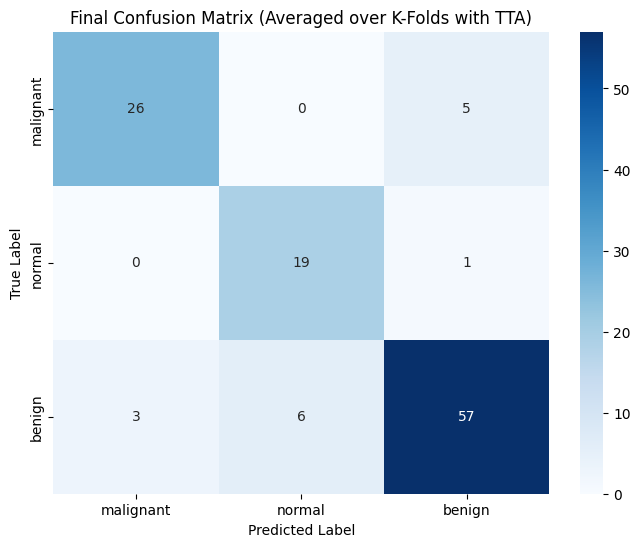

In [23]:
# TTA Transforms
tta_transforms = [
    A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
]

# Create a dataset for TTA without shuffle
test_dataset = BreastCancerDataset(X_test, y_test, transform=None) # No default transform
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

all_tta_preds = []

for fold in range(n_splits):
    # Load the best model for the current fold
    model = CNNViTHybrid(num_classes=len(classes)).to(device)
    model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))
    model.eval()

    fold_tta_preds = []
    with torch.no_grad():
        for img_path in tqdm(test_dataset.image_paths, desc=f"TTA on Fold {fold+1}"):
            image_np = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
            
            tta_outputs = []
            for transform in tta_transforms:
                augmented = transform(image=image_np)
                image_tensor = augmented['image'].unsqueeze(0).to(device)
                output = model(image_tensor)
                tta_outputs.append(output.cpu())
            
            # Average the predictions (softmax probabilities)
            avg_preds = torch.mean(torch.stack([torch.softmax(out, dim=1) for out in tta_outputs]), dim=0)
            fold_tta_preds.append(avg_preds)
    
    all_tta_preds.append(torch.cat(fold_tta_preds))

# Average predictions across all folds
final_preds_proba = torch.mean(torch.stack(all_tta_preds), dim=0)
_, final_preds = torch.max(final_preds_proba, 1)

# --- Final Reports ---
print("\n--- Final Classification Report (Averaged over K-Folds with TTA) ---")
print(classification_report(y_test, final_preds.numpy(), target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Final Confusion Matrix (Averaged over K-Folds with TTA)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

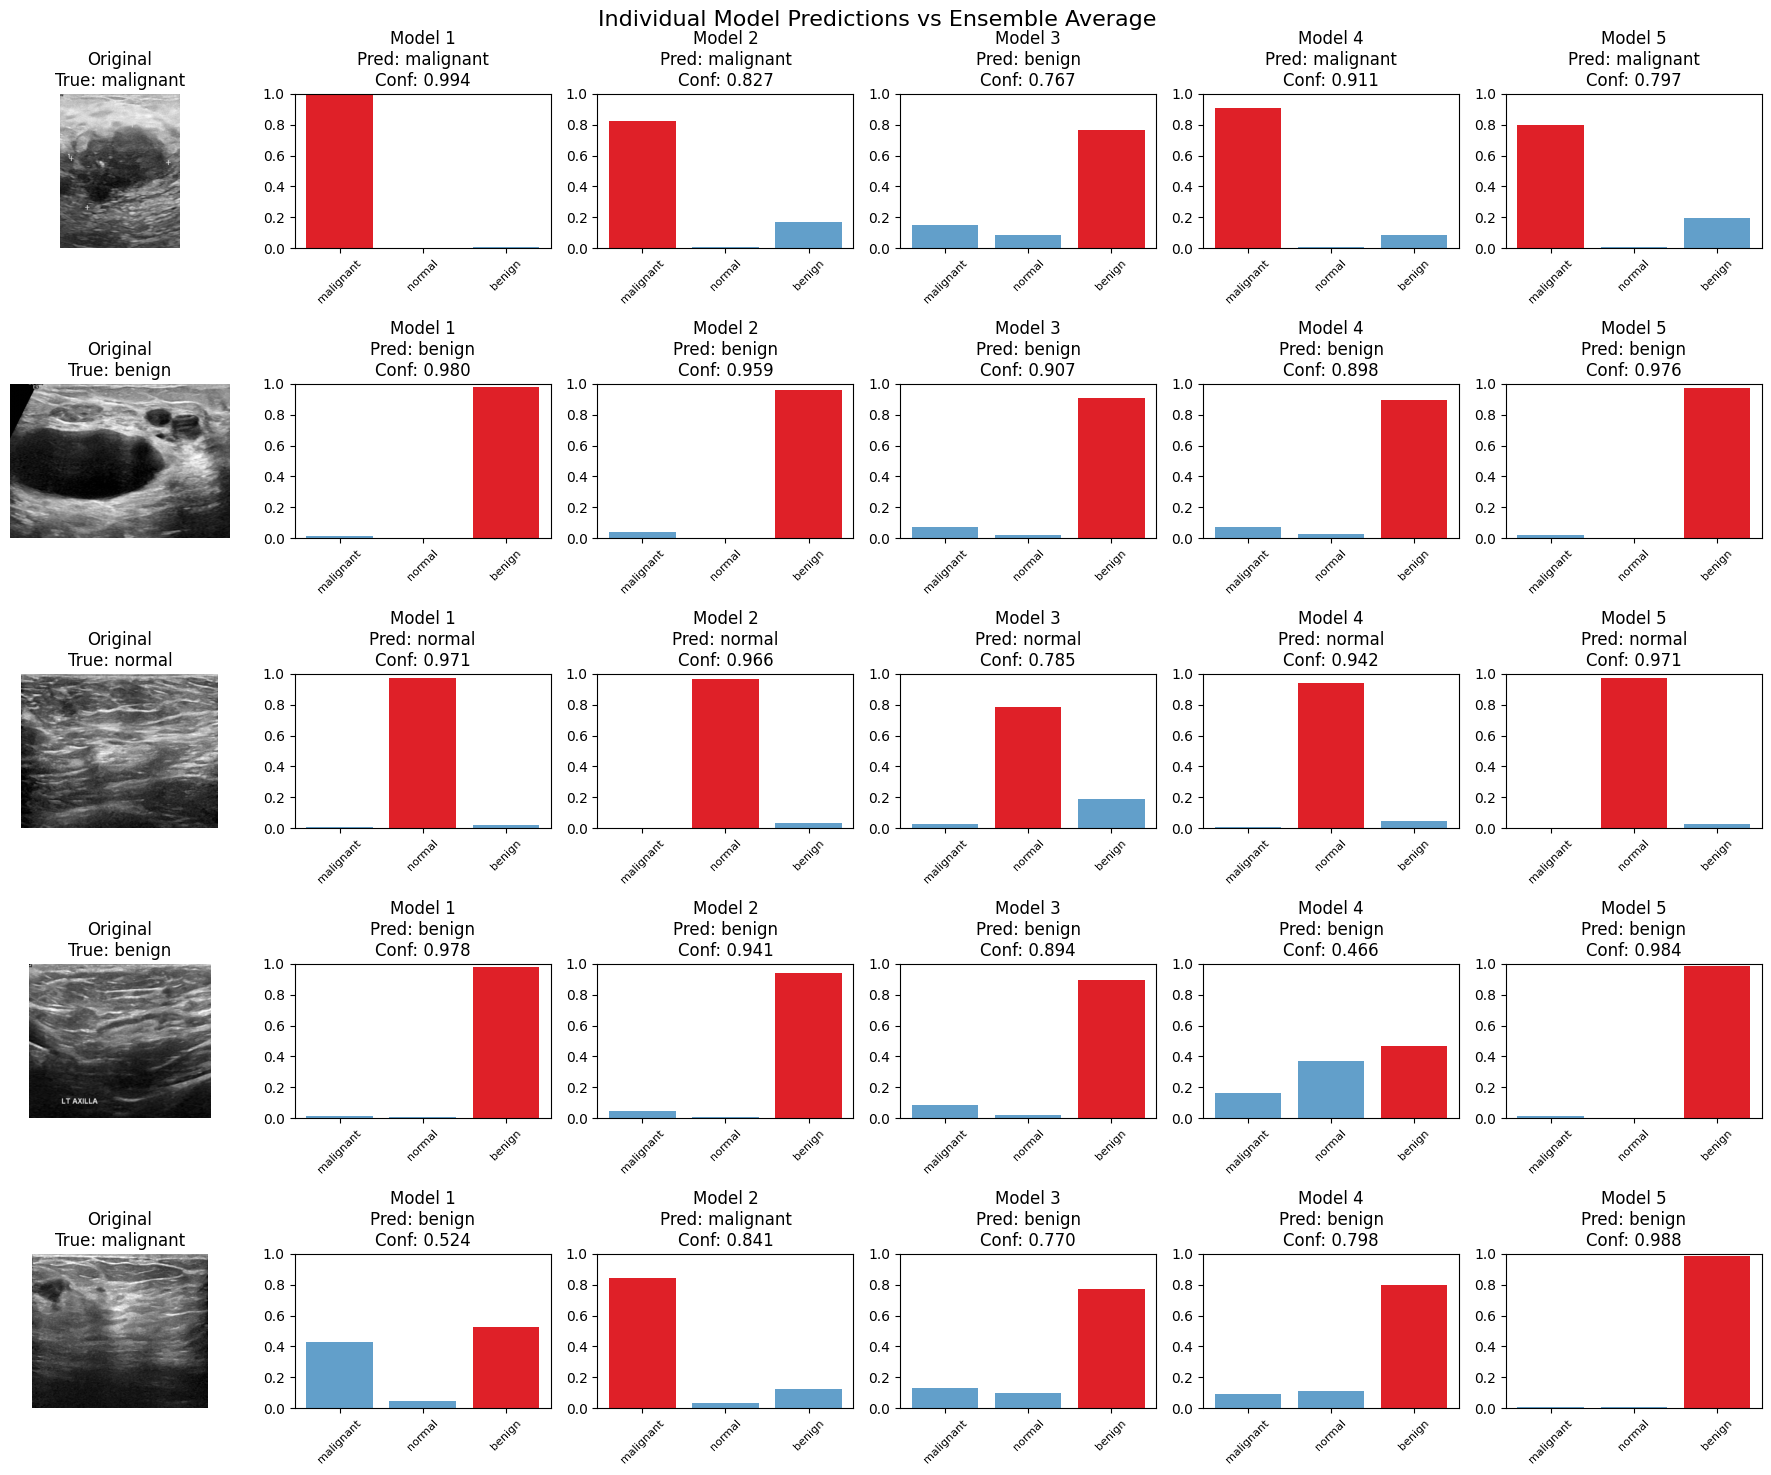

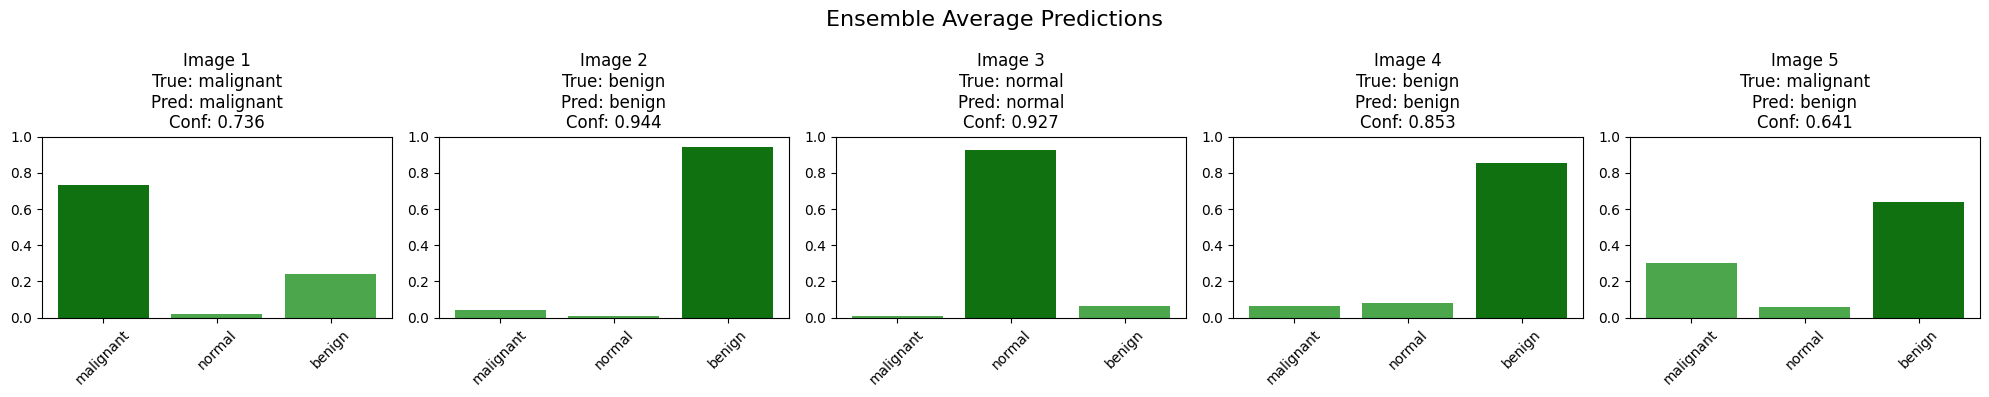

In [24]:
# Visualize Example Predictions from All Models
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
fig.suptitle('Individual Model Predictions vs Ensemble Average', fontsize=16)

# Select 5 random test images
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 5, replace=False)

for i, idx in enumerate(sample_indices):
    # Load and display original image
    img_path = X_test[idx]
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f'Original\nTrue: {classes[y_test[idx]]}')
    axes[i, 0].axis('off')
    
    # Show predictions from each fold
    for fold in range(n_splits):
        fold_pred_proba = all_tta_preds[fold][idx].numpy()
        fold_pred_class = np.argmax(fold_pred_proba)
        confidence = fold_pred_proba[fold_pred_class]
        
        axes[i, fold+1].bar(classes, fold_pred_proba, alpha=0.7)
        axes[i, fold+1].set_title(f'Model {fold+1}\nPred: {classes[fold_pred_class]}\nConf: {confidence:.3f}')
        axes[i, fold+1].set_ylim(0, 1)
        axes[i, fold+1].tick_params(axis='x', rotation=45, labelsize=8)
        
        # Highlight predicted class
        axes[i, fold+1].bar(classes[fold_pred_class], fold_pred_proba[fold_pred_class], 
                           color='red', alpha=0.8)

plt.tight_layout()
plt.show()

# Show ensemble predictions for the same images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Ensemble Average Predictions', fontsize=16)

for i, idx in enumerate(sample_indices):
    ensemble_pred_proba = final_preds_proba[idx].numpy()
    ensemble_pred_class = np.argmax(ensemble_pred_proba)
    confidence = ensemble_pred_proba[ensemble_pred_class]
    
    axes[i].bar(classes, ensemble_pred_proba, alpha=0.7, color='green')
    axes[i].set_title(f'Image {i+1}\nTrue: {classes[y_test[idx]]}\nPred: {classes[ensemble_pred_class]}\nConf: {confidence:.3f}')
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Highlight predicted class
    axes[i].bar(classes[ensemble_pred_class], ensemble_pred_proba[ensemble_pred_class], 
               color='darkgreen', alpha=0.8)

plt.tight_layout()
plt.show()

# 6. Summary and Findings

This notebook implemented a robust pipeline for breast tumor classification using a hybrid CNN-Transformer model.

**Key Enhancements:**
1. **Advanced Augmentation:** Utilized `albumentations` for a more diverse set of image transformations, improving the model's ability to generalize.
2. **K-Fold Cross-Validation:** The model was trained and validated across 5 stratified folds. This provides a much more reliable estimate of its true performance and reduces the chance of a "lucky" train/validation split biasing the results.
3. **Learning Rate Scheduling & Early Stopping:** The training process was optimized to prevent overfitting and find a better convergence point by dynamically adjusting the learning rate and stopping when performance on the validation set plateaued.
4. **Test-Time Augmentation (TTA):** The final evaluation was strengthened by averaging predictions on both original and flipped test images, leading to more stable and accurate final predictions.

**Potential Next Steps:**
* **Hyperparameter Tuning:** Use a framework like Optuna or Ray Tune to systematically search for the best hyperparameters for the model architecture (e.g., `embed_dim`, `nhead`) and optimizer.
* **Crop to ROI:** As discussed, a two-stage pipeline where a segmentation model first identifies the tumor region could significantly improve focus and performance.
* **Ensemble Methods:** Instead of averaging the K-Fold models, one could explore more sophisticated ensembling techniques.